# Passange Survival by Fare paid on HMS Titanic 

[Kaggle Competition](https://www.kaggle.com/c/titanic)

In [0]:
# EDA
import numpy as np
import pandas as pd
#import modin.pandas as pd
import missingno
import seaborn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime as dt
from pandas.plotting import scatter_matrix
from xgboost import plot_importance

# preprocessing
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
import sklearn.decomposition

# algos
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras

In [130]:
# load data
!wget https://raw.githubusercontent.com/erinkhoo/hard-skill-learning-list-2019/master/Machine_Learning_Problems/train.csv
!wget https://raw.githubusercontent.com/erinkhoo/hard-skill-learning-list-2019/master/Machine_Learning_Problems/test.csv

# DataFrame the data
dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')

--2020-05-20 11:40:04--  https://raw.githubusercontent.com/erinkhoo/hard-skill-learning-list-2019/master/Machine_Learning_Problems/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘train.csv.5’

train.csv.5         100%[===================>]  59.76K  --.-KB/s    in 0.002s  

2020-05-20 11:40:04 (26.1 MB/s) - ‘train.csv.5’ saved [61194/61194]

--2020-05-20 11:40:07--  https://raw.githubusercontent.com/erinkhoo/hard-skill-learning-list-2019/master/Machine_Learning_Problems/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awai

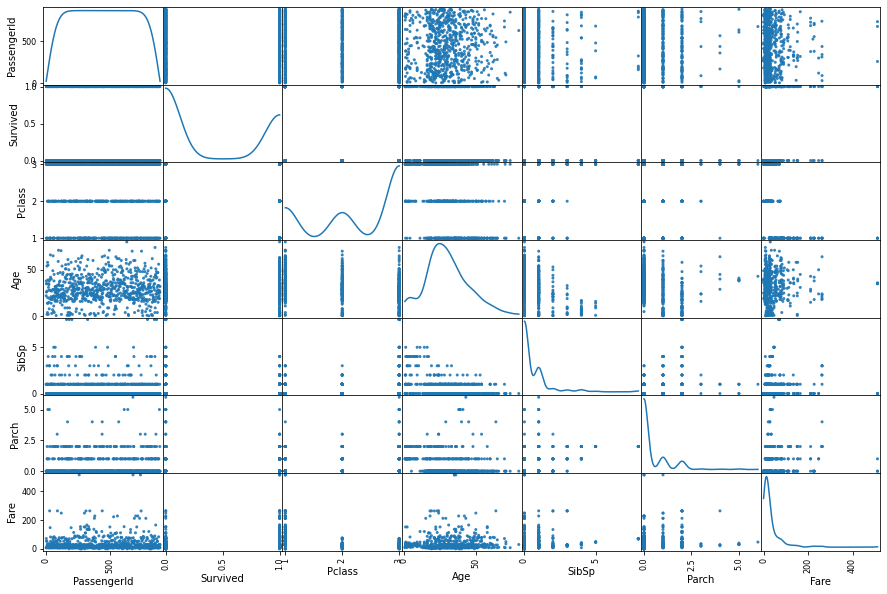

In [97]:
# scatterplot matrix on numerical features
scatter_matrix(dftrain, figsize=(15,10), alpha=.9, diagonal='kde')
plt.show()

In [3]:
# dtype data review
dftrain.info()
print(f'========================================')
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [4]:
# check missing values
dftrain.isnull().sum()
#dftest.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [131]:
# only 1 value for 'Fare' missing
print(dftrain['Fare'].mean())
print(dftrain['Fare'].median())
print(dftrain['Fare'].mode())

impute = dftest['Fare'].median()

dftest['Fare'].fillna(impute, inplace=True)

32.2042079685746
14.4542
0    8.05
dtype: float64


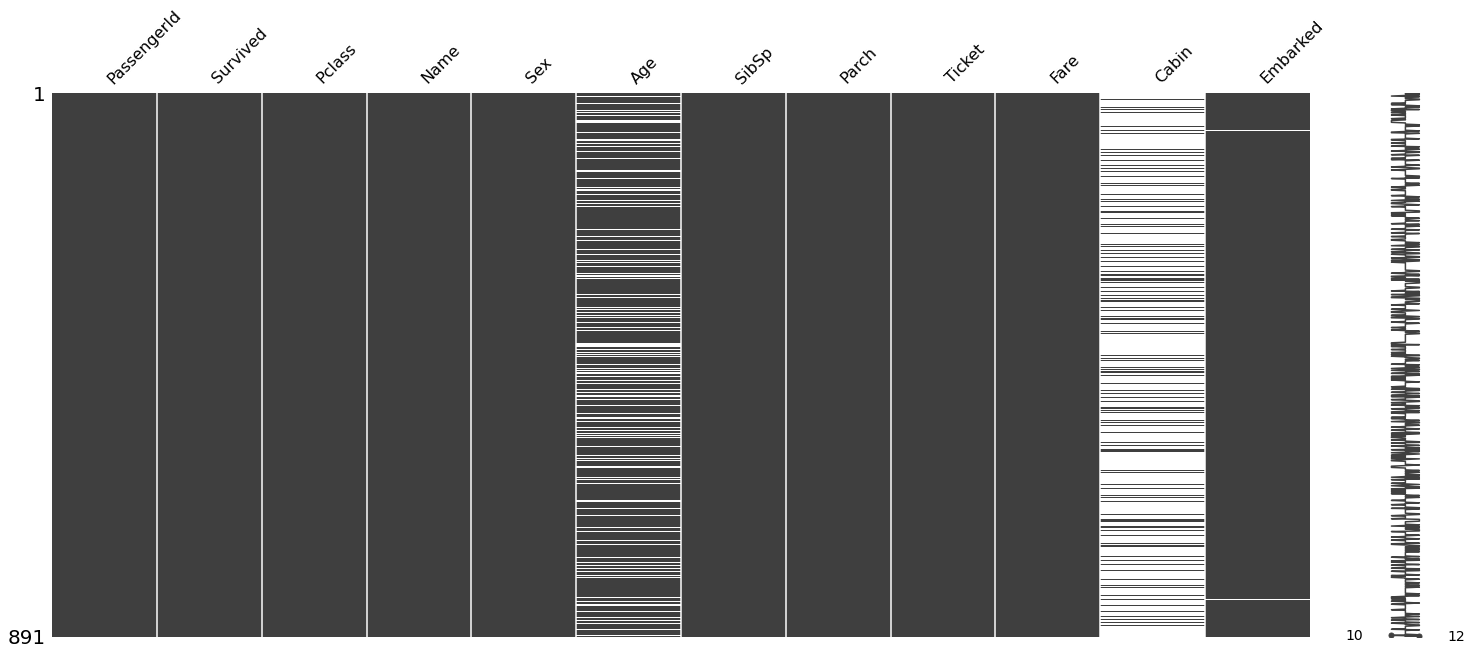

In [8]:
# train dataset missing values
missingno.matrix(dftrain)
plt.show()

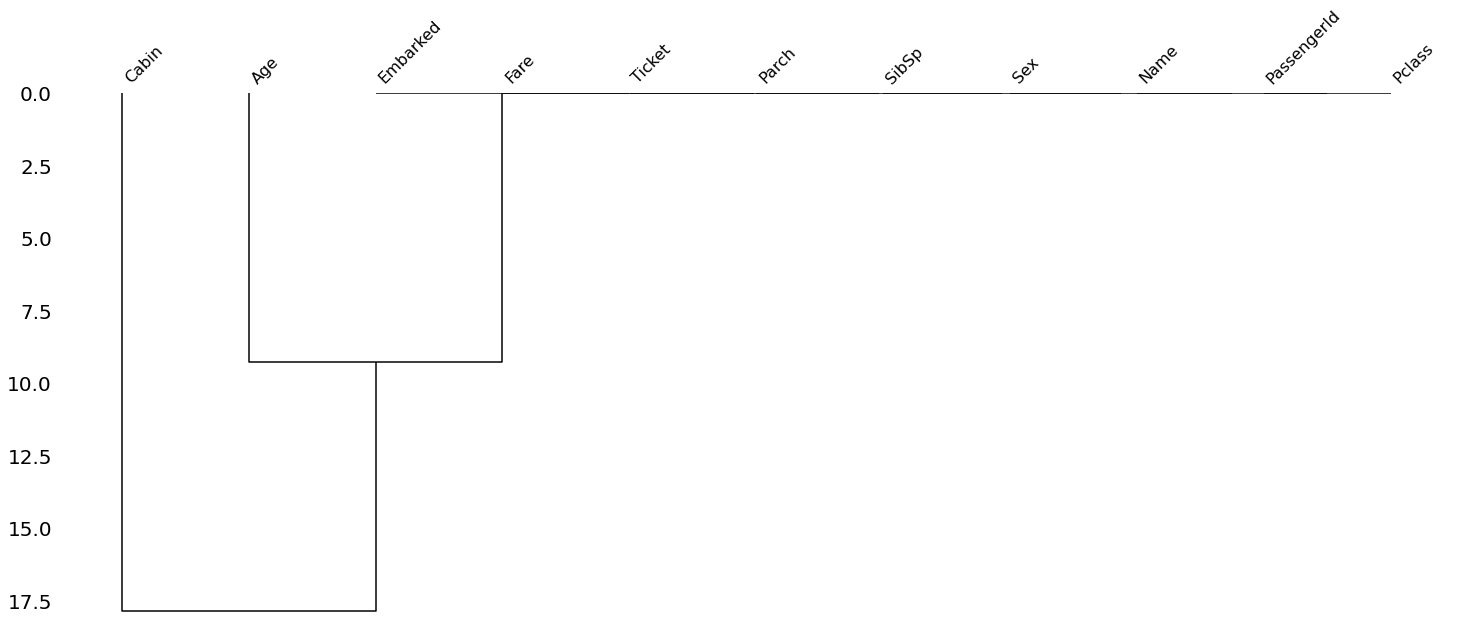

In [9]:
# test dataset missing values
missingno.dendrogram(dftest)
plt.show()

In [103]:
# 
dftrain.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup
662,663,0,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S,40-49
460,461,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,E12,S,40-49
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,20-29


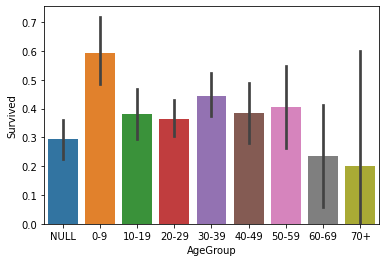

In [132]:
#sort the ages into logical categories
dftrain["Age"] = dftrain["Age"].fillna(-0.5)
dftest["Age"] = dftest["Age"].fillna(-0.5)

bins = [-1, 0, 10, 20, 30, 40, 50, 60, 70, np.inf]
labels = ['NULL', '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
dftrain['AgeGroup'] = pd.cut(dftrain["Age"], bins, labels = labels)
dftest['AgeGroup'] = pd.cut(dftest["Age"], bins, labels = labels)

# #draw a bar plot of Age vs. survival
seaborn.barplot(x="AgeGroup", y="Survived", data=dftrain)
plt.show()

In [0]:
#Delete 'AgeGroup' since we don't need it anymore
for df in [dftrain, dftest]:
  del(df['AgeGroup'])

In [0]:
# turn 'Sex' (female|male) into a category dtype
dftrain['Sex'] = dftrain['Sex'].astype('category')
dftest['Sex'] = dftest['Sex'].astype('category')

In [17]:
dftrain['Sex'].cat.codes
dftest['Sex'].cat.codes

0      1
1      0
2      1
3      1
4      0
      ..
413    1
414    0
415    1
416    1
417    1
Length: 418, dtype: int8

In [0]:
# turn 'AgeGroup' into a category dtype
dftrain['AgeGroup'] = dftrain['AgeGroup'].astype('category')
dftest['AgeGroup'] = dftest['AgeGroup'].astype('category')

In [16]:
dftrain['AgeGroup'].cat.codes
dftest['AgeGroup'].cat.codes

0      4
1      5
2      7
3      3
4      3
      ..
413    0
414    4
415    4
416    0
417    0
Length: 418, dtype: int8

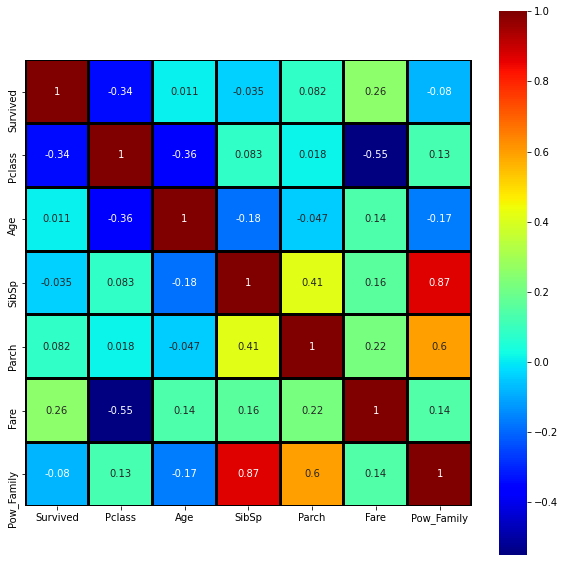

In [107]:
# correlation review
corr_matrix_train = dftrain.drop(['PassengerId'], axis=1).corr()
corr_matrix_test = dftest.drop(['PassengerId'], axis=1).corr()

f, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(corr_matrix_train, annot=True, square=True,
                cmap='jet', linewidths=2, linecolor='black')
plt.show()

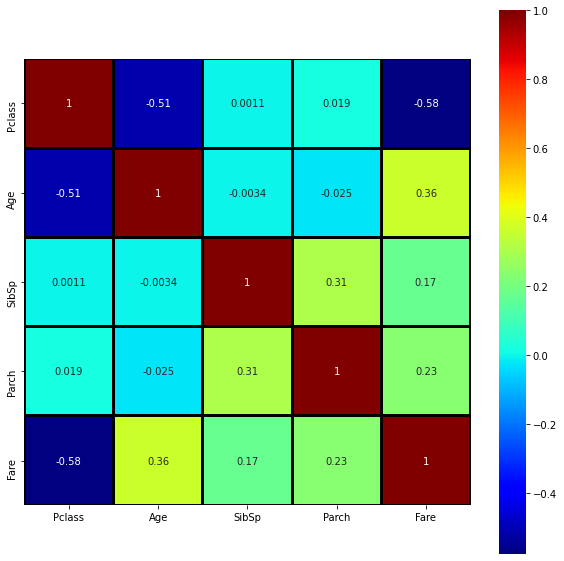

In [106]:
f, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(corr_matrix_test, annot=True, square=True,
                cmap='jet', linewidths=2, linecolor='black')
plt.show()

In [20]:
corr_matrix_train['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
Age         0.011497
SibSp      -0.035322
Pclass     -0.338481
Name: Survived, dtype: float64

In [0]:
# feature engineering
# (SibSp+Parch)^2
dftrain['Pow_Family'] = (dftrain['SibSp'] + dftrain['Parch'])**2
dftest['Pow_Family'] = (dftest['SibSp'] + dftest['Parch'])**2

In [114]:
print(f'{dftrain}')

     PassengerId  Survived  Pclass  ... Embarked AgeGroup  Pow_Family
0              1         0       3  ...        S    20-29           1
1              2         1       1  ...        C    30-39           1
2              3         1       3  ...        S    20-29           0
3              4         1       1  ...        S    30-39           1
4              5         0       3  ...        S    30-39           0
..           ...       ...     ...  ...      ...      ...         ...
886          887         0       2  ...        S    20-29           0
887          888         1       1  ...        S    10-19           0
888          889         0       3  ...        S     NULL           9
889          890         1       1  ...        C    20-29           0
890          891         0       3  ...        Q    30-39           0

[891 rows x 14 columns]


In [136]:
# feature engineering
# Age

age_by_pclass_sex_train = dftrain.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
   for sex in ['female', 'male']:
     print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex_train[sex][pclass]))

age_by_pclass_sex_test = dftest.groupby(['Sex', 'Pclass']).median()['Age']
print(f'====')
for pclass in range(1, 4):
   for sex in ['female', 'male']:
     print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex_train[sex][pclass]))

Median age of Pclass 1 females: 32.5
Median age of Pclass 1 males: 36.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.0
Median age of Pclass 3 females: 15.5
Median age of Pclass 3 males: 21.0
====
Median age of Pclass 1 females: 32.5
Median age of Pclass 1 males: 36.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.0
Median age of Pclass 3 females: 15.5
Median age of Pclass 3 males: 21.0


In [0]:
# Filling the missing values in Age with the medians of Sex and Pclass groups for train and text
dftrain['Age'] = dftrain.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
dftest['Age'] = dftest.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

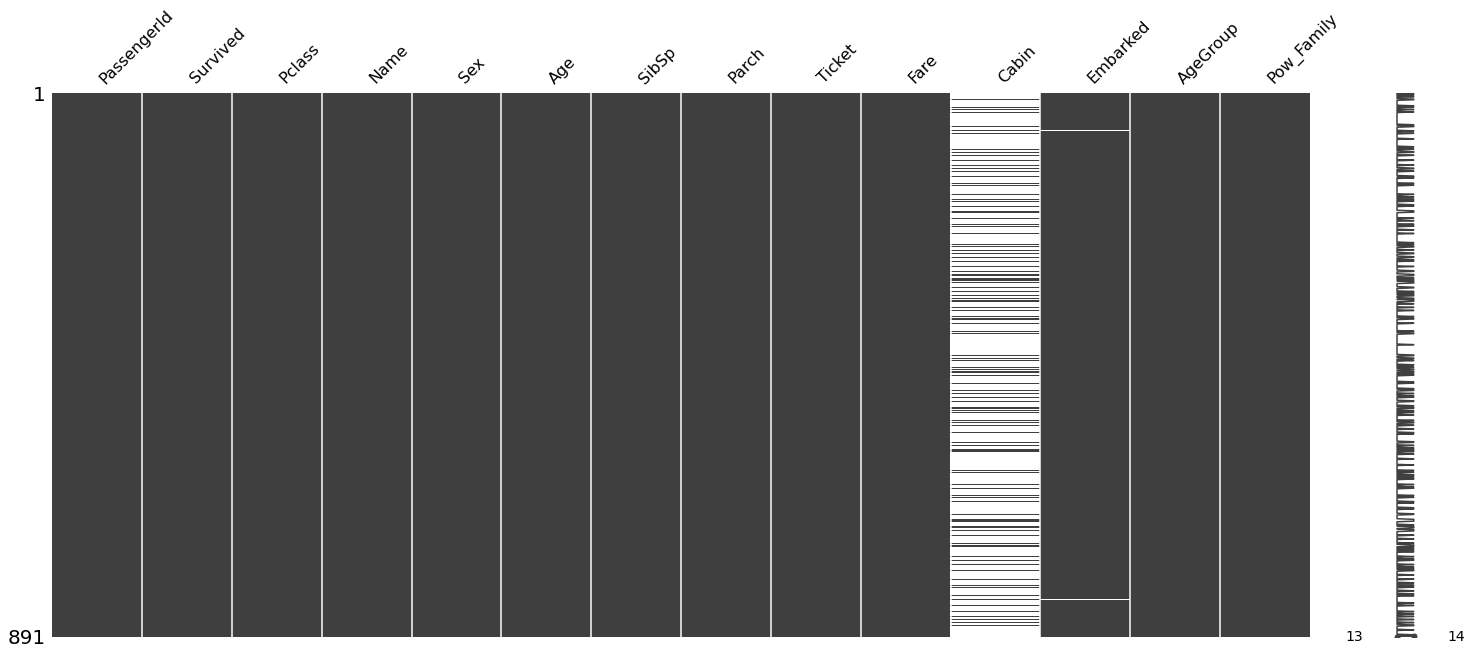

In [140]:
# train dataset missing values after processing
missingno.matrix(dftrain)
#missingno.matrix(dftest)
plt.show()

In [0]:
# predictor selection
predictors_train = pd.concat([dftrain['Pclass'], dftrain['Fare'], dftrain['Pow_Family'], dftrain['Sex'].cat.codes, dftrain['Age']], axis=1)
predictors_test = pd.concat([dftest['Pclass'], dftest['Fare'], dftest['Pow_Family'], dftest['Sex'].cat.codes, dftrain['Age']], axis=1)

In [144]:
# predictor review
predictors_train.sample(5)

,Pclass,Fare,Pow_Family,0,Age
784,3,7.0500,0,1,25.0
505,1,108.9000,1,1,18.0
836,3,8.6625,0,1,21.0
334,1,133.6500,1,0,-0.5
714,2,13.0000,0,1,52.0


#### Scale Data (predictors) for VotingClassifier 

---

estimators who are not Decision Tree based
`PowerTransformer`: 

In [0]:
PowerTransformer = PowerTransformer()
predictors_train_PTscaled = PowerTransformer.fit_transform(predictors_train)
predictors_test_PTscaled = PowerTransformer.fit_transform(predictors_test)

`MinMaxScaler`: 

In [0]:
MMScaler = MinMaxScaler()
predictors_train_MMscaled = MMScaler.fit_transform(predictors_train)
predictors_test_MMscaled = MMScaler.fit_transform(predictors_test)

In [0]:
# set X and y values (This is a DataFrame so need to state .values to get a np.array)
#X_train = predictors_train.values
#X_test = predictors_test.values

# set X and y values with scaled NumPy Array (This is already a NumPy Array)
# PowerTransformer
#X_train = predictors_train_PTscaled
#X_test = predictors_test_PTscaled

# set X and y values with scaled NumPy Array (This is already a NumPy Array)
# MinMaxScaler
X_train = predictors_train_MMscaled
X_test = predictors_test_MMscaled
# target variable
y_train = dftrain['Survived'].values

In [26]:
# synth_y_test creation since we do not have a pure 'y_test' from the Raw dataset
# 418 randomly selected ['Outcome'] values from dftrain

synth_y_test = dftrain['Survived'].sample(418)
print(f'{synth_y_test}')

524    0
428    0
888    0
149    0
34     0
      ..
782    0
326    0
487    0
688    0
235    0
Name: Survived, Length: 418, dtype: int64


In [72]:
# training sample review
X_train[:5]

array([[1.        , 0.01415106, 0.01      , 1.        ],
       [0.        , 0.13913574, 0.01      , 0.        ],
       [1.        , 0.01546857, 0.        , 0.        ],
       [0.        , 0.1036443 , 0.01      , 0.        ],
       [1.        , 0.01571255, 0.        , 1.        ]])

In [71]:
# target variable sample review
y_train[:5]

array([0, 1, 1, 1, 0])

#### Grid Search; LR

In [0]:
# Grid Search | LR
model_LogReg = LogisticRegression()

# Create regularization hyperparameter space
C = [1, 2, 3, 4]

In [0]:
# LogisticRegression params
params_LR={'penalty': ['l2', 'none'],
              'C': [0.5, 1, 2, 3, 4],
              'solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [50, 100, 150, 200, 500]}

In [0]:
# LogisticRegression Grid Search
grid_LogReg = GridSearchCV(model_LogReg,
                            params_LR,
                            n_jobs=-1,
                            scoring='neg_mean_squared_error')

In [0]:
# fit LR model
grid_LogReg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.5, 1, 2, 3, 4],
                         'max_iter': [50, 100, 150, 200, 500],
                         'penalty': ['l2', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_

In [0]:
# best LR paremeters
# {'C': 1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'} | NOT Scaled
# {'C': 0.5, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'} | Scaled
grid_LogReg.best_params_

{'C': 0.5, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}

### Logistic Regression Model

In [0]:
# tuned model
model_LogReg_tuned = LogisticRegression(C=.5, max_iter=50, penalty='l2', solver='newton-cg')

In [0]:
# fit tuned model to data
model_LogReg_tuned.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# predict
y_train_pred = model_LogReg_tuned.predict(X_train)
y_test_pred = model_LogReg_tuned.predict(X_test)

#print(f'{y_train_pred}')
#print(f'===============================================================')
#print(f'{y_test_pred}')

In [0]:
#compute training error
M = np.hstack([y_train[:,None],y_train_pred[:,None]])
print(f'{M}')

[[0 0]
 [1 1]
 [1 1]
 ...
 [0 1]
 [1 0]
 [0 0]]


In [0]:
# Accuracy Score
# 
# PT Scaled - 78.676%
# MM Scaled - 78.9%
print(f'{(y_train == y_train_pred).mean()*100:.5}%')

78.9001%


In [0]:
# generate output .csv from NumPy Array - NOT WORKING
X_test.PassengerId, y_test_pred

In [0]:
# generate output .csv from DataFrame
output = pd.DataFrame({'PassengerId': dftest.PassengerId, 'Survived': y_test_pred})
output.to_csv('my_submission.csv', index=False)
print(f'Submission was successfully saved!')

Submission was successfully saved!


#### Grid Search & Random Search; XGBoost

In [0]:
# Grid Search | XGBoost
model_xgb = XGBClassifier(tree_method='gpu_hist', n_jobs=-1)

In [0]:
# XGB parameters
params_XGB ={'max_depth': [5,6,7,8,9,10],
              'n_estimators': [50,75,100,150],
              'booster': ['gbtree'],
              'gamma': [0.0, 0.0001, 0.001, 0.01],
              'learning_rate': [0.1, 0.2, 0.25, 0.3, 0.35]}

In [0]:
# RandomizedSearchCV
rand_XGB = RandomizedSearchCV(model_xgb,
                              params_XGB,
                              n_jobs=-1,
                              n_iter=25,
                              scoring='neg_mean_squared_error',
                              verbose=1)

In [0]:
# GridSearchCV
grid_XGB = GridSearchCV(model_xgb,
                        params_XGB,
                        n_jobs=-1,
                        scoring='neg_mean_squared_error',
                        verbose=1)

In [76]:
# fit XGB model
rand_XGB.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.8min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=...
                                           tree_method='gpu_hist',
                                           verbosity=1),
                   iid='deprecated', n_iter=25, n_jobs

In [0]:
# fit XGB model
grid_XGB.fit(X_train, y_train)

In [77]:
# best XGB paremeters
###{'booster': 'gbtree', 'gamma': 0.1, 'learning_rate': 0.35, 'max_depth': 4, 'n_estimators': 100}; GRID
###{'booster': 'gbtree', 'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50}; GRID
###{'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.25, 'gamma': 0.0, 'booster': 'gbtree'}; RAND
###{'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.01, 'booster': 'gbtree'}; RAND

###{'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.01, 'booster': 'gbtree'}; RAND
print(f'{rand_XGB.best_params_}')
#grid_XGB.best_params_

{'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.01, 'booster': 'gbtree'}


In [78]:
# best XGB estimator
#XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#             colsample_bynode=1, colsample_bytree=1, gamma=0.1,
#             importance_type='gain', learning_rate=0.35, max_delta_step=0,
#             max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
#             n_jobs=1, nthread=None, objective='reg:squarederror',
#             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#             seed=None, silent=None, subsample=1, verbosity=1)
#grid_XGB.best_estimator_
rand_XGB.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=75, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

### XGBoost Classifier

In [0]:
# tuned model
model_XGBC_tuned = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, booster='gbtree', gamma=.01, learning_rate=.1, max_depth=8, n_estimators=75)

In [80]:
# fit tuned model to data
model_XGBC_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=75, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [0]:
# 
y_train_predxgb = model_XGBC_tuned.predict(X_train)
y_test_predxgb = model_XGBC_tuned.predict(X_test)

#print(f'{y_train_predxgb}')
#print(f'===============================================================')
#print(f'{y_test_predxgb}')

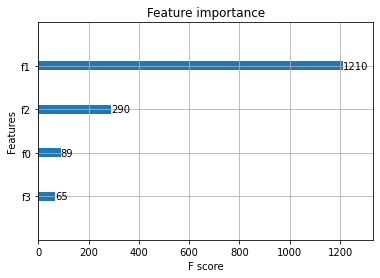

In [82]:
# plot feature importance
plot_importance(model_XGBC_tuned, show_values=True)
plt.show()

In [83]:
#compute training error
M = np.hstack([y_train[:,None],y_train_predxgb[:,None]])
print(f'{M}')

[[0 0]
 [1 1]
 [1 1]
 ...
 [0 0]
 [1 1]
 [0 0]]


In [84]:
# ACCURACY SCORE, why don't I have a 'y_test'...
# try synth_y_test...
#accuracy_xgb = accuracy_score(y_test, y_test_predxgb)

accuracy_xgb = accuracy_score(synth_y_test, y_test_predxgb)
print(f'XGBClassifier Accuracy {accuracy_xgb*100:.5} %')

XGBClassifier Accuracy 55.502 %


In [85]:
# generate output .csv from DataFrame and np.array
output = pd.DataFrame({'PassengerId': dftest.PassengerId, 'Survived': y_test_predxgb})
output.to_csv('my_submission.csv', index=False)
print(f'Submission was successfully saved!')

Submission was successfully saved!


## Voting Classifier

In [0]:
# voting_clf ensemble
log_clf = LogisticRegression(C=.5, max_iter=50, penalty='l2', solver='newton-cg')
erf_clf = ExtraTreesClassifier()
svm_clf = SVC(probability=True)
xgb_clf = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, booster='gbtree', gamma=.01, learning_rate=0.1, max_depth=8, n_estimators=75)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('erf', erf_clf), ('svm', svm_clf), ('xgb', xgb_clf)],
    voting='soft')

In [87]:
#
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.5, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=50,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='newton-cg', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('erf',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None...
                                            

In [0]:
# predicted target y using voting_clf ensemble
#y_pred_vc = voting_clf.predict(X_train)
y_pred = voting_clf.predict(X_test)

In [90]:
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [91]:
# ACCURACY SCORE, why don't I have a 'y_test'???
# try synth_y_test...
accuracy_voting = accuracy_score(synth_y_test, y_pred)
print(f'Voting Classifier Accuracy {accuracy_voting*100:.5} %')

Voting Classifier Accuracy 55.742 %


In [94]:
# generate output .csv from DataFrame and np.array
output = pd.DataFrame({'PassengerId': dftest.PassengerId, 'Survived': y_pred})
output.to_csv('my_submission.csv', index=False)
print(f'Submission was successfully saved!')

Submission was successfully saved!


In [93]:
# accuracy score review
for clf in (log_clf, erf_clf, svm_clf, xgb_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(f'{clf.__class__.__name__}: {accuracy_score(synth_y_test, y_pred):.6f}')

LogisticRegression: 0.552632
ExtraTreesClassifier: 0.533493
SVC: 0.552632
XGBClassifier: 0.555024
VotingClassifier: 0.557416


---

### Tensorflow Classification

In [0]:
# data review
print(f'X Train:        {X_train.shape}')
print(f'X Test:         {X_test.shape}')
print(f'================')
print(f'y Train:        {y_train.shape}')
print(f'synth y Test:   {synth_y_test.shape}')

X Train:        (891, 3)
X Test:         (418, 3)
y Train:        (891,)
synth y Test:   (418,)


In [0]:
# create model structure
tfmodel = keras.models.Sequential([
                                   keras.layers.Dense(12, activation='relu', input_shape=(3,)),
                                   keras.layers.Dense(8, activation='relu'),
                                   keras.layers.Dropout(.333),
                                   keras.layers.Dense(1, activation='sigmoid')])

In [0]:
# summary
tfmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 12)                48        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 104       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile model
tfmodel.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [0]:
# store history of model epochs
history = 0
history = tfmodel.fit(X_train, y_train,
                      validation_split=.2, epochs=150)

Epoch 1/150
23/23 [==============================] - 0s 8ms/step - loss: 0.6385 - accuracy: 0.6110 - val_loss: 0.6025 - val_accuracy: 0.6425
Epoch 2/150
23/23 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6517 - val_loss: 0.5941 - val_accuracy: 0.7318
Epoch 3/150
23/23 [==============================] - 0s 4ms/step - loss: 0.6166 - accuracy: 0.6685 - val_loss: 0.5807 - val_accuracy: 0.7486
Epoch 4/150
23/23 [==============================] - 0s 4ms/step - loss: 0.6099 - accuracy: 0.6615 - val_loss: 0.5695 - val_accuracy: 0.7598
Epoch 5/150
23/23 [==============================] - 0s 4ms/step - loss: 0.6023 - accuracy: 0.6812 - val_loss: 0.5596 - val_accuracy: 0.7598
Epoch 6/150
23/23 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.6896 - val_loss: 0.5538 - val_accuracy: 0.7598
Epoch 7/150
23/23 [==============================] - 0s 4ms/step - loss: 0.5933 - accuracy: 0.7177 - val_loss: 0.5452 - val_accuracy: 0.7598
Epoch 8/150
2

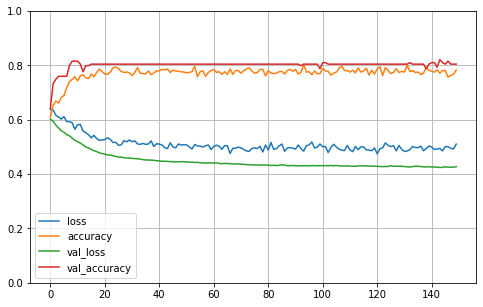

{'verbose': 1, 'epochs': 150, 'steps': 23}


In [0]:
# plt model metrics
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
print(f'{history.params}')

In [0]:
# predict classes on X_test
temp_y_pred = tfmodel.predict_classes(X_test)
tf_y_pred = temp_y_pred.ravel()
#print(f'{tf_y_pred}')

In [0]:
# evaluate model
#
print(f'METRICS:  {tfmodel.metrics_names}')
print(f'TEST:     {tfmodel.evaluate(X_test, tf_y_pred)}')
print(f'TRAIN:    {tfmodel.evaluate(X_train, y_train)}')

METRICS:  ['loss', 'accuracy']
14/14 [==============================] - 0s 2ms/step - loss: 0.3024 - accuracy: 1.0000
TEST:     [0.30243468284606934, 1.0]
28/28 [==============================] - 0s 2ms/step - loss: 0.4556 - accuracy: 0.7890
TRAIN:    [0.4556123614311218, 0.7890011072158813]


In [0]:
# save model
tfmodel.save('tf-binary_crossentropy-RMSProp.h5')

In [0]:
# ACCURACY SCORE, why don't I have a 'y_test'???
# try synth_y_test...
accuracy_voting = accuracy_score(synth_y_test, tf_y_pred)
print(f'TensorFlow Classifier Accuracy {accuracy_voting*100:.5} %')

TensorFlow Classifier Accuracy 51.435 %


In [0]:
# generate output .csv from DataFrame and np.array
output = pd.DataFrame({'PassengerId': dftest.PassengerId, 'Survived': tf_y_pred})
output.to_csv('my_submission.csv', index=False)
print(f'Submission was successfully saved!')

Submission was successfully saved!


---